## Data preparation - PDF pre-processing

The Data Preparation phase of the IBM's CRISP model is about preparing the final dataset to be used in the later stages. In this phase, the table, record, and attribute selection, as well as transformation and cleaning are considered. Practice shows that these tasks are likely to be performed multiple times.

This notebook focuses on the extraction of the 5 statement categories (mission, visions, core values, strategies, goals) from PDF files. At the end, a csv/json files are produced which is the data we will feed the model to determine the final candidates for the 5 above-mentioned pillars.

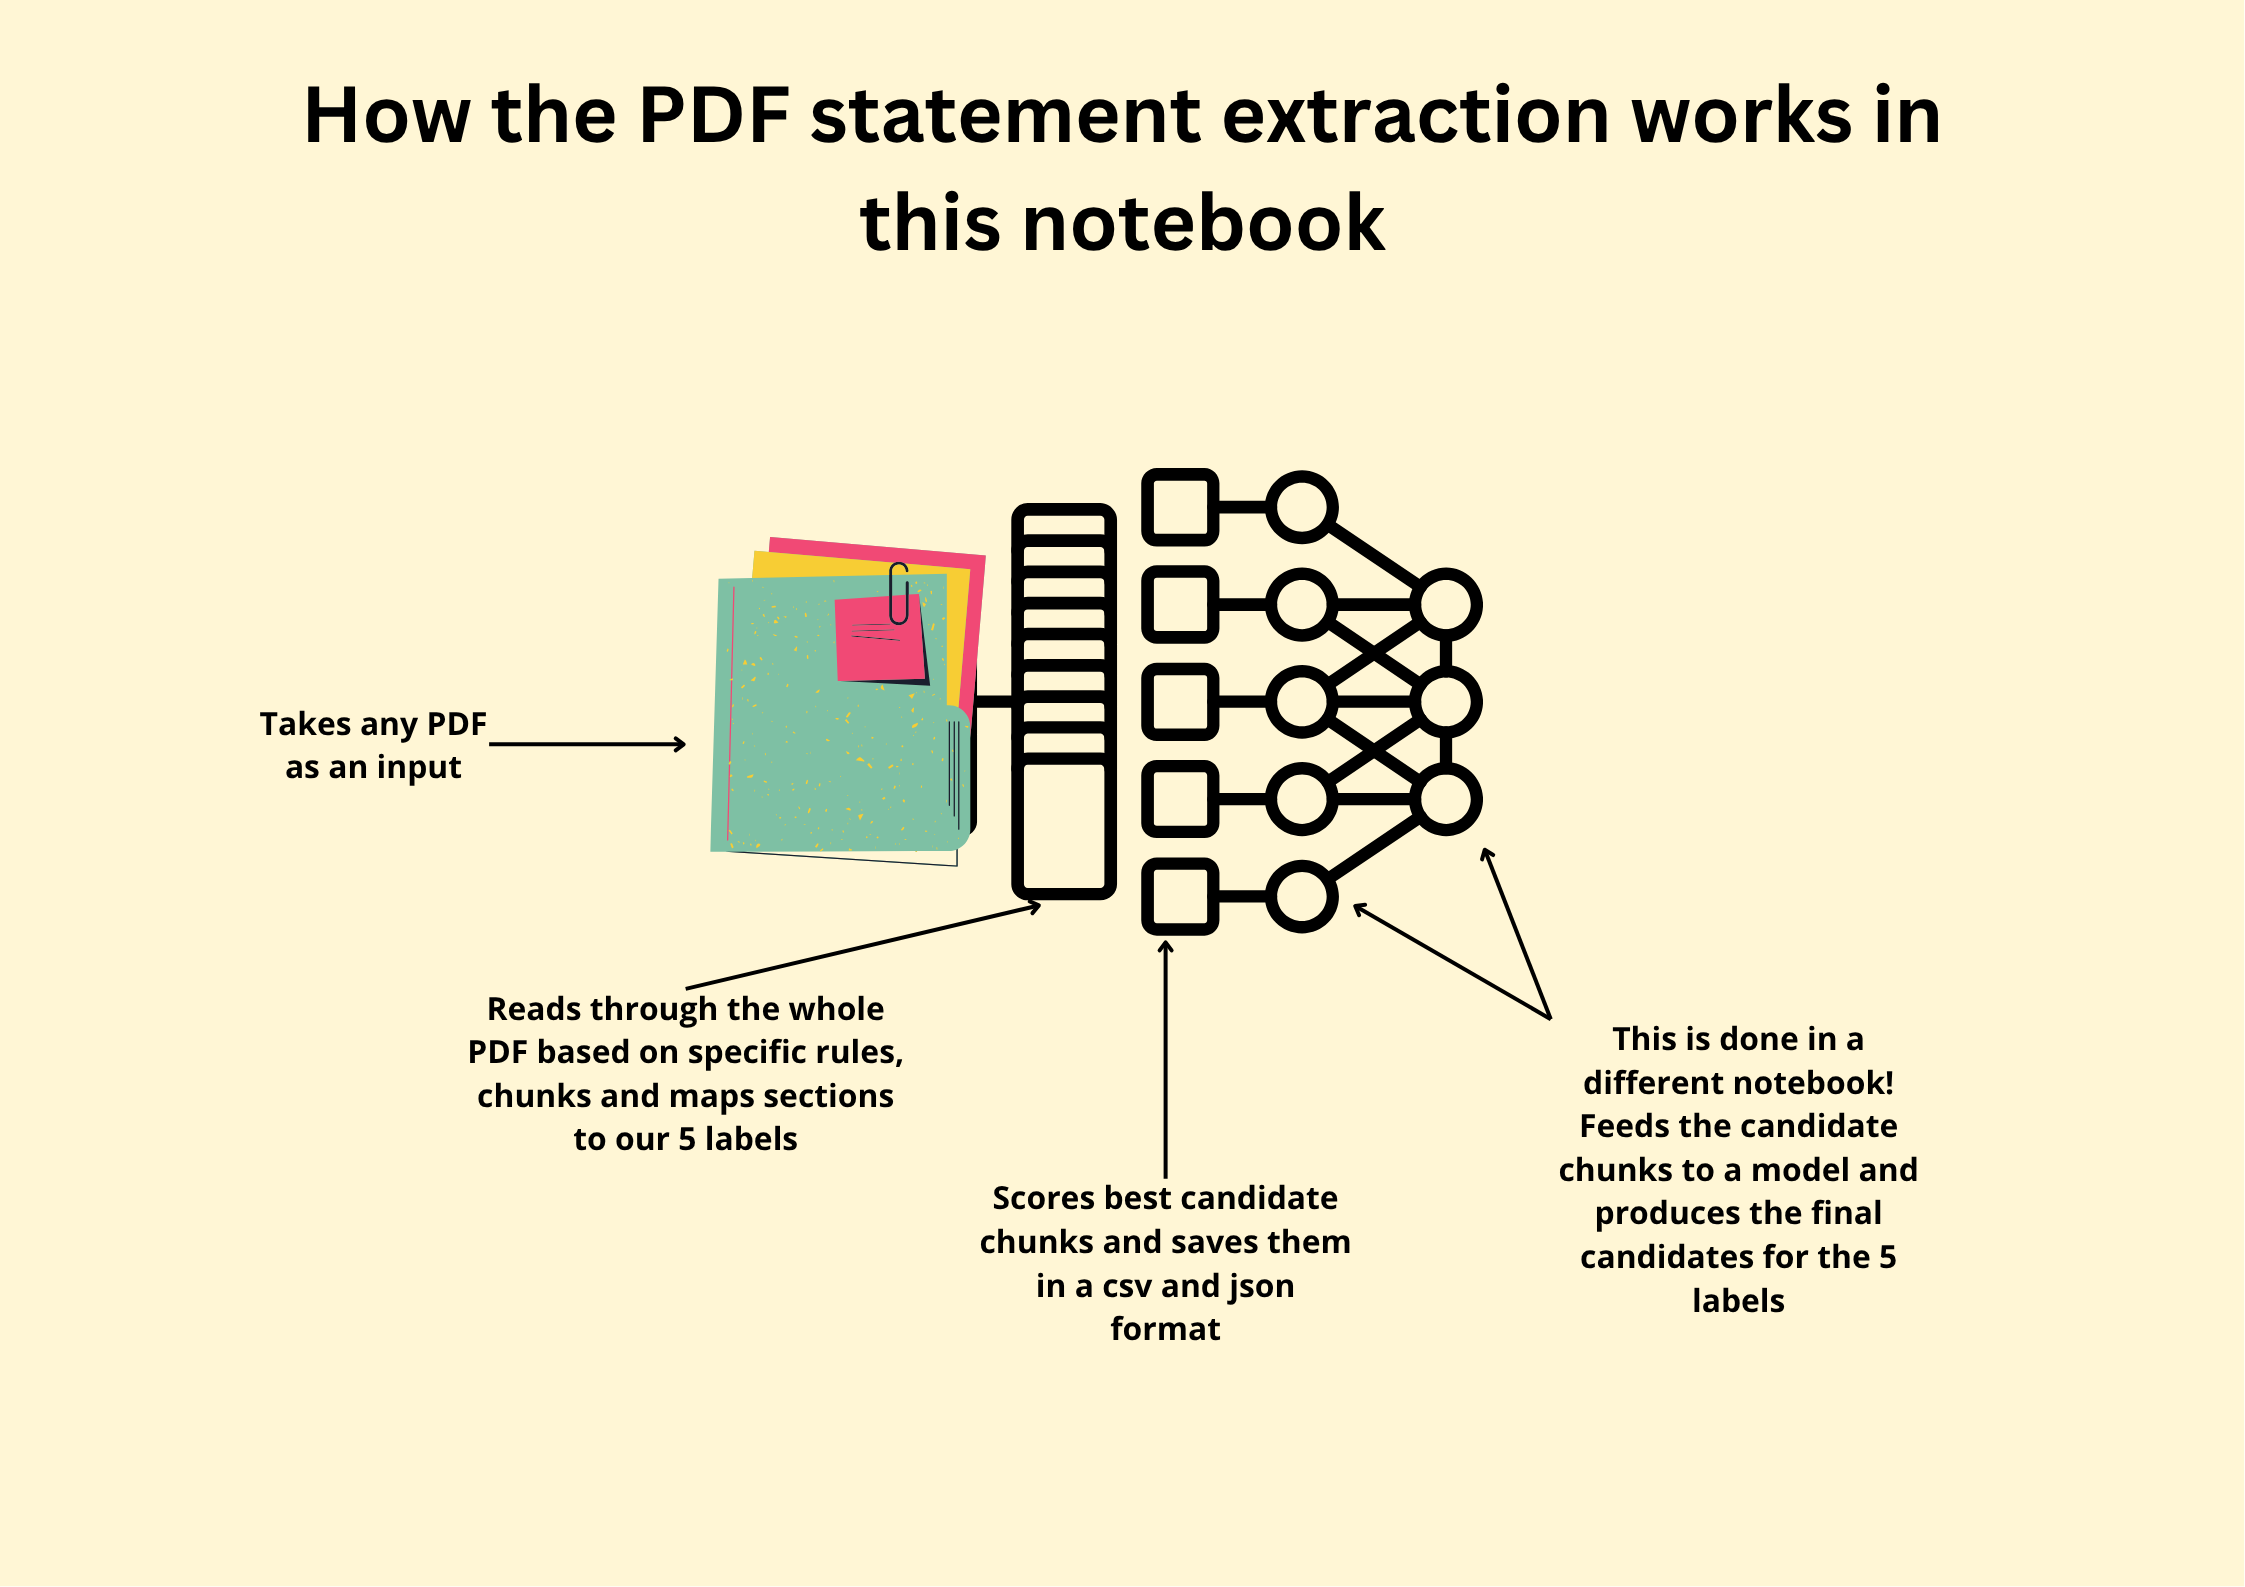


## 1) Setup
Handels the necessary installation of packages.

In [1]:
# Python imports
import re, io, json, sys, platform
import requests
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import fitz
import unicodedata
from IPython.display import display
from ipywidgets import interact, IntSlider
from PIL import Image
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity


print("Python", sys.version.split()[0], "| OS:", platform.platform())
print("PyMuPDF", fitz.__doc__.splitlines()[0] if fitz.__doc__ else "OK")


Python 3.13.5 | OS: Windows-11-10.0.26100-SP0
PyMuPDF PyMuPDF 1.26.7: Python bindings for the MuPDF 1.26.12 library (rebased implementation).


## 2) Configuration

### This part of the notebook defines how the system recognizes which topic a paragraph belongs to, when there is no clear section heading in the PDF.

*   With "LABELS" we define the five organizational elements we want to detect in an annual report.


*   With "GENERIC_HINTS" define keywords that are commonly associated with each label



In [2]:
LABELS = ["Mission","Vision","Goals","Core Values","Strategy"]

GENERIC_HINTS = {
    "Mission": [
        # EN
        r"\bmission\b",
        r"\bpurpose\b",
        r"\bour purpose\b",
        r"\bwhy we exist\b",
        r"\breason for being\b",
        # NL
        r"\bmissie\b",
        r"\bonze missie\b",
        r"\bwaarom we bestaan\b",
        r"\bbestaansreden\b",
        r"\b(onze|ons)\s+doel\b"
    ],
    "Vision": [
        # EN (common in annual reports even when 'vision' isn't used)
        r"\bvision\b",
        r"\bour vision\b",
        r"\baspiration\b",
        r"\bwhere we (want|aim) to be\b",
        r"\bfuture direction\b",
        r"\bour future\b",
        r"\blong[-\s]?term\b.{0,30}\b(ambition|aspiration|vision)\b",
        r"\b(ambition|aspiration)\b.{0,30}\b(long[-\s]?term|future)\b",
        # NL
        r"\bvisie\b",
        r"\bonze visie\b",
        r"\bwaar we naartoe willen\b",
        r"\btoekomstbeeld\b",
        r"\bonze toekomst\b",
        r"\blange termijn\b.{0,30}\b(ambitie|visie)\b",
        r"\bambitie\b.{0,30}\b(lange termijn|toekomst)\b"
    ],
    "Goals": [
        # EN
        r"\bgoals?\b",
        r"\btargets?\b",
        r"\bobjectives?\b",
        r"\bKPIs?\b",
        # NL
        r"\bdoelen?\b",
        r"\bdoelstelling(en)?\b",
        r"\bKPI'?s?\b",
        r"\btargets?\b"
    ],
    "Core Values": [
        # EN
        r"\b(core\s+)?values?\b",
        r"\bguiding principles?\b",
        r"\bwhat we stand for\b",
        r"\bour\s+(culture|dna)\b",
        r"\bbehaviou?rs?\b",
        # NL
        r"\bkernwaarden\b",
        r"\bwaarden\b",
        r"\bleidende principes?\b",
        r"\bwaar wij voor staan\b",
        r"\b(onze|ons)\s+(cultuur|dna)\b"
    ],
    "Strategy": [
        # EN
        r"\bstrategy\b",
        r"\bstrategic\b",
        r"\bbusiness model\b",
        r"\bvalue creation\b",
        r"\bpillars?\b",
        # NL
        r"\bstrategie\b",
        r"\bstrategisch(e)?\b",
        r"\bbedrijfsmodel\b",
        r"\bwaardecreatie\b",
        r"\b(pijlers|pilaren)\b"
    ],
}

GENERIC_PAT = {k: [re.compile(p, re.I) for p in v] for k, v in GENERIC_HINTS.items()}

## 3) Parsing utilities

This function reads each PDF page, falls back to OCR if there’s no text layer, reconstructs two-column reading order using x-positions, keeps font sizes for header detection, cleans minor noise, and returns both full page text and line-by-line data for the later extraction steps.

In [3]:
# Parsing utilities 
try:
    import pytesseract
    OCR_AVAILABLE = True
except Exception:
    OCR_AVAILABLE = False

def strip_noise(text: str) -> str:
    if not text:
        return ""
    text = re.sub(r"(?m)^\s*\d{1,4}\s*$", "", text)                 # page numbers
    text = re.sub(r"(?mi)^\s*(©|copyright)\b.*$", "", text)         # copyright lines
    text = re.sub(r"\n{3,}", "\n\n", text).strip()                  # blank lines
    return text

def ocr_page(page, dpi=250):
    if not OCR_AVAILABLE:
        return ""
    try:
        pix = page.get_pixmap(dpi=dpi)
        img = Image.open(io.BytesIO(pix.tobytes(output="png")))
        return pytesseract.image_to_string(img)
    except Exception:
        return ""

def _assign_column(x0: float, bin_size: int = 80) -> int:
    return int(round(x0 / bin_size))

def page_text_with_lines(doc, ocr_dpi=250, x_bin=80):
    pages = []

    for pno in range(len(doc)):
        page = doc[pno]
        raw = page.get_text("dict")

        columns = {}     # col_id -> list[(y0, txt, max_sz)]
        col_x = {}       # col_id -> representative x (for stable sorting)

        for b in raw.get("blocks", []):
            if "lines" not in b:
                continue

            bx0 = b.get("bbox", (0, 0, 0, 0))[0]
            col_id = _assign_column(bx0, bin_size=x_bin)
            col_x[col_id] = min(col_x.get(col_id, bx0), bx0)

            for l in b.get("lines", []):
                spans = l.get("spans", [])
                if not spans:
                    continue

                # Join spans with space to avoid word-gluing; then normalize spaces
                txt = " ".join(s.get("text", "") for s in spans).strip()
                txt = re.sub(r"\s{2,}", " ", txt)
                if not txt:
                    continue

                max_sz = max((s.get("size", 0) for s in spans), default=0)
                y0 = min((s.get("bbox", [0, 0, 0, 0])[1] for s in spans), default=0)

                columns.setdefault(col_id, []).append((y0, txt, max_sz))

        stitched = []
        # Sort columns by actual x position (more stable than col_id)
        for col_id in sorted(columns.keys(), key=lambda cid: col_x.get(cid, cid)):
            for y0, txt, sz in sorted(columns[col_id], key=lambda t: t[0]):
                stitched.append((txt, sz))

        structured_text = "\n".join(t for t, _ in stitched).strip()

        # OCR fallback if no text layer
        if not structured_text:
            structured_text = ocr_page(page, dpi=ocr_dpi).strip()
            if structured_text:
                stitched = [(ln.strip(), 0) for ln in structured_text.splitlines() if ln.strip()]

        full = strip_noise(structured_text)

        pages.append({
            "page": pno,
            "lines": stitched,
            "text": full
        })

    return pages

## 4) Header detection + header→label mapping

### In the next cell we detect headings using font size, caps, and regex; map the heading text to one of five categories (Mission, Vision, Goals, Core Values, Strategy) using English/Dutch synonyms; then capture the following paragraphs as that section’s content, with size limits and hyphenation repair.

In [4]:
# -----------------------------
# 1) Header detection patterns (stricter + safer)
# -----------------------------

# Map header words → our five labels (used ONLY as a hint for "is this a header?")
HEADER_PATTERNS = [
    # English (keep relatively strict; start-of-line anchors)
    r"^(mission|purpose)\b",  # keep Mission/Purpose here (Mission already works)
    r"^(vision)\b",
    r"^(strategy)\b",
    r"^(core values?|values?)\b",
    r"^(goals?|objectives?|targets?|kpi'?s?)\b",

    # Strategy synonyms (EN)
    r"^(strategic (priorities|pillars|framework|themes))\b",
    r"^(value creation|business model|operating model)\b",

    # Vision synonyms (EN) — common in annual reports
    r"^(our )?(ambition|aspiration|future|future direction|long[-\s]?term (ambition|aspiration|direction))\b",
    r"^(where we (want|aim) to be)\b",

    # Values synonyms (EN)
    r"^(our )?(culture|dna|behaviou?rs?|code of conduct|how we act|what we stand for)\b",

    # Goals synonyms (EN)
    r"^(commitments?|roadmap|milestones?)\b",

    # Dutch
    r"^(missie)\b",  # Mission works already
    r"^(visie)\b",
    r"^(strategie)\b",
    r"^(kernwaarden|waarden)\b",
    r"^(doelen?|doelstellingen?|targets?|kpi'?s?)\b",

    # Strategy synonyms (NL)
    r"^(strategische (prioriteiten|pijlers|kaders|thema's|themas))\b",
    r"^(waardecreatie|bedrijfsmodel)\b",

    # Vision synonyms (NL)
    r"^(onze )?(ambitie|toekomst|toekomstbeeld|lange termijn (ambitie|visie)|richting)\b",
    r"^(waar we naartoe willen)\b",

    # Values synonyms (NL)
    r"^(onze )?(cultuur|dna|gedrag|gedragsprincipes|code of conduct|waar wij voor staan)\b",

    # Goals synonyms (NL)
    r"^(routekaart|mijlpalen|commitments?)\b",
]
HEADER_RE = [re.compile(p, re.I) for p in HEADER_PATTERNS]

# Optional: filter out common non-GEA headers that cause huge irrelevant blocks
BAD_HEADER_WORDS = re.compile(
    r"\b(contents|table of contents|index|notes to|financial statements|annex|appendix)\b",
    re.I
)

def _looks_like_title(line: str) -> bool:
    """Reject captions/menus/long sentences, but allow real headers like 'Our ambition:'."""
    s = (line or "").strip()
    if not s:
        return False
    if len(s) > 100:
        return False

    # If it matches header keywords or header->label patterns, be more permissive
    keywordish = any(r.search(s) for r in HEADER_RE) or any(
        r.search(s) for regs in HEADER_TO_LABEL_RE.values() for r in regs
    )

    # avoid mostly numbers/symbols
    if sum(c.isalpha() for c in s) < max(5, int(0.35 * len(s))):
        return False

    # Avoid sentence-like endings; allow ':' because headings often use it
    if s.endswith(".") or s.endswith(";"):
        return False

    if BAD_HEADER_WORDS.search(s):
        return False

    # If not keywordish, enforce shorter length to avoid captions
    if not keywordish and len(s) > 70:
        return False

    return True


# -----------------------------
# 2) Header → label mapping (scored, avoids dict-order bias)
# -----------------------------

HEADER_TO_LABEL_PATTERNS = {
    "Mission": [
        r"\b(our\s+)?mission\b", r"\bour purpose\b", r"\bpurpose statement\b",
        r"\bwhy we exist\b", r"\bthe reason we exist\b", r"\bcompany purpose\b",
        r"\bmissie\b", r"\bonze missie\b", r"\bwaarom we bestaan\b",
        r"\b(onze|ons)\s+doel\b", r"\bwaar wij voor bestaan\b", r"\b(bestaansreden)\b"
    ],

    # --- Vision (expanded) ---
    "Vision": [
        r"\b(our\s+)?vision\b", r"\bshared vision\b",
        r"\b(our\s+)?ambition\b", r"\baspiration\b",
        r"\bfuture direction\b", r"\bour future\b",
        r"\blong[-\s]?term\b", r"\bwhere we (want|aim) to be\b",
        r"\b(visie)\b", r"\bonze visie\b",
        r"\b(onze\s+)?ambitie\b", r"\btoekomstbeeld\b",
        r"\blange termijn\b.{0,30}\b(ambitie|visie)\b",
        r"\bonze toekomst\b", r"\bwaar we naartoe willen\b",
        r"\brichting\b"  # common Dutch phrasing: "richting 2030"
    ],

    # --- Goals (expanded) ---
    "Goals": [
        r"\bgoals?\b", r"\bobjectives?\b", r"\btargets?\b", r"\bcommitments?\b",
        r"\bperformance goals?\b", r"\bkey (performance )?indicators?\b", r"\bKPIs?\b",
        r"\bwhat we aim to achieve\b",
        r"\bmilestones?\b", r"\broadmap\b",
        r"\b(doelen?)\b", r"\bdoelstelling(en)?\b", r"\bprestatie-indicatoren\b", r"\bKPI'?s?\b",
        r"\bonze doelstelling(en)?\b", r"\bwat we willen bereiken\b",
        r"\bmijlpalen\b", r"\broutekaart\b",
        r"\b(202\d|203\d|2050)\b.{0,30}\b(targets?|doelen?|kpi'?s?)\b"  # year-target headers
    ],

    # --- Core Values (expanded) ---
    "Core Values": [
        r"\bcore values?\b", r"\bcompany values?\b", r"\bwhat we stand for\b",
        r"\bour culture\b", r"\bguiding principles?\b", r"\bbeliefs?\b", r"\bethical principles?\b",
        r"\bcode of conduct\b", r"\bhow we act\b", r"\bbehaviou?rs?\b", r"\bour dna\b",
        r"\bkernwaarden\b", r"\bonze waarden\b", r"\bwaar wij voor staan\b", r"\bonze cultuur\b",
        r"\bleidende principes?\b", r"\bovertuigingen\b",
        r"\bgedrag\b", r"\b(onze|ons)\s+dn?a\b",
        # broad terms kept
        r"\bvalues?\b", r"\bwaarden\b"
    ],

    # --- Strategy (expanded) ---
    "Strategy": [
        r"\bstrategy\b", r"\bstrategic\b",
        r"\bstrategic priorities\b", r"\bstrategic pillars?\b", r"\bstrategic framework\b", r"\bstrategic themes\b",
        r"\bstrategy execution\b",
        r"\bbusiness model\b", r"\boperating model\b", r"\bvalue creation\b",
        r"\bour plan\b", r"\bhow we create value\b",
        r"\bstrategie\b", r"\bstrategisch(e)?\b", r"\bstrategische prioriteiten\b",
        r"\bstrategische pijlers?\b", r"\bstrategisch kader\b", r"\bstrategische thema's\b", r"\bstrategische themas\b",
        r"\bbedrijfsmodel\b", r"\bwaardecreatie\b", r"\bhoe wij waarde creëren\b", r"\bons plan\b"
    ]
}

HEADER_TO_LABEL_RE = {
    lab: [re.compile(p, re.I) for p in pats]
    for lab, pats in HEADER_TO_LABEL_PATTERNS.items()
}


# -----------------------------
# 3) Header decision (less strict where annual reports need it)
# -----------------------------

def is_header(line: str, size: float, avg_size: float) -> bool:
    s = (line or "").strip()

    if not _looks_like_title(s):
        return False

    size_hint = size >= (avg_size * 1.20)
    strong_size = size >= (avg_size * 1.35)

    regex_hint = any(r.search(s) for r in HEADER_RE)

    allcaps_hint = (
        s.isupper()
        and len(s) <= 70
        and len(s.split()) <= 10
        and (size_hint or regex_hint)
    )

    if regex_hint and not size_hint and not strong_size:
        return len(s) <= 35

    return size_hint or allcaps_hint or (regex_hint and strong_size)


# -----------------------------
# 4) Header → label (scored, avoids dict-order bias)
# -----------------------------

def infer_label_from_header(header_text: str):
    s = (header_text or "").strip()
    scores = {lab: 0 for lab in HEADER_TO_LABEL_RE.keys()}

    for lab, regs in HEADER_TO_LABEL_RE.items():
        for r in regs:
            if r.search(s):
                scores[lab] += 1

    best = max(scores, key=scores.get)
    return best if scores[best] > 0 else None


# -----------------------------
# 5) Build blocks under each header
# -----------------------------

def build_blocks_from_headers(lines, window_lines: int = 60, char_cap: int = 2600):
    if not lines:
        return []

    avg = sum(sz for _, sz in lines) / max(1, len(lines))
    headers = [i for i, (t, sz) in enumerate(lines) if is_header(t, sz, avg)]

    blocks = []
    for idx in headers:
        header_text = (lines[idx][0] or "").strip()
        hint_label = infer_label_from_header(header_text)

        buf = [header_text]
        chars = len(header_text)

        for j in range(idx + 1, min(len(lines), idx + 1 + window_lines)):
            t, sz = lines[j]
            if is_header(t, sz, avg):
                break

            t = (t or "").strip()
            if not t:
                continue

            buf.append(t)
            chars += len(t) + 1
            if chars >= char_cap:
                break

        block_text = "\n".join(buf).strip()
        block_text = re.sub(r"(\w)-\n(\w)", r"\1\2", block_text)
        block_text = re.sub(r"\n(?!\n)", " ", block_text)

        if len(block_text) >= 50:
            blocks.append({"text": block_text, "hint_label": hint_label})

    return blocks

## 5) Front matter sampling

Not all important statements (like mission or vision) appear under clear headings. Very often, they appear in the first few pages — for example, in the CEO letter, introduction, or company overview.
This function extracts meaningful text blocks from the beginning of the report, even when no header is present. So it acts as a safety net that allows the system to still find relevant content when the document layout does not follow standard section headings.

In [5]:
FRONT_MATTER_SKIP_RE = re.compile(
    r"\b(table of contents|contents|index|forward-looking statements|"
    r"cautionary statement|disclaimer|legal|glossary|definitions|"
    r"auditor'?s report|independent auditor|remuneration report|"
    r"notes to the financial statements|financial statements)\b",
    re.I
)

def collect_front_matter(pages, first_pages: int = 30, block_char_cap: int = 2000, overlap_paras: int = 0):
    """
    Extracts paragraph-based blocks from the first N pages (front matter).
    Safety net when headings are missing.
    """
    blocks = []

    for pg in pages[:min(first_pages, len(pages))]:
        raw = (pg.get("text") or "").strip()
        if not raw:
            continue

        # If page looks like TOC/legal, skip UNLESS it also contains MVGS cues
        if FRONT_MATTER_SKIP_RE.search(raw):
            has_mvgs = False
            for lab, regs in GENERIC_PAT.items():
                if any(r.search(raw) for r in regs):
                    has_mvgs = True
                    break
            if not has_mvgs:
                continue

        # Fix hyphenation BEFORE spacing changes
        raw = re.sub(r"(\w)-\n(\w)", r"\1\2", raw)

        # Normalize spaces but keep newlines
        raw = re.sub(r"[ \t]+", " ", raw).strip()

        # Split paragraphs:
        # - double newline usually indicates paragraphs
        # - also split on very common "poster-like" pages where each line is a bullet/heading
        paras = [p.strip() for p in re.split(r"\n{2,}", raw) if p.strip()]

        # If we got a single mega-paragraph, fall back to line-based chunks
        if len(paras) <= 1:
            paras = [p.strip() for p in raw.split("\n") if p.strip()]

        # Light paragraph filter
        cleaned_paras = []
        for p in paras:
            if len(p) < 60 and len(p.split()) < 8:
                continue
            # Skip short boilerplate lines
            if FRONT_MATTER_SKIP_RE.search(p) and len(p) < 300:
                continue
            cleaned_paras.append(p)

        if not cleaned_paras:
            continue

        # Pack paragraphs into blocks
        buf, chars = [], 0
        for p in cleaned_paras:
            if chars + len(p) + 1 > block_char_cap:
                if buf:
                    blocks.append("\n".join(buf))

                if overlap_paras > 0:
                    buf = buf[-overlap_paras:] if len(buf) >= overlap_paras else buf[:]
                    chars = sum(len(x) + 1 for x in buf)
                else:
                    buf, chars = [], 0

            buf.append(p)
            chars += len(p) + 1

        if buf:
            blocks.append("\n".join(buf))

    return blocks

## 6) Fallback weak labeling + scoring


*   label_by_generic_rules - It checks how many keywords associated with each label appear in the text. For each label, it counts matches from GENERIC_PAT (which holds regex patterns for EN + NL keywords).It selects the label with the highest count (the most keyword matches).



*   score_block - this function scores how well the text matches both the meaning and typical size of the labeled category, improving reliability.



In [6]:
def label_by_generic_rules(text: str, min_score: int = 1, margin: int = 0, prefer: str = None):
    """
    Counts keyword hits per label and selects best label.
    - min_score: if best score < min_score -> Other
    - margin: if best is too close to second-best -> Other (uncertain)
      NOTE: margin=1 is often too strict for small hit counts; default 0.
    - prefer: optional label to break ties (e.g., header hint)
    Returns: (label, best_score, scores_dict)
    """
    t = text or ""
    scores = {k: sum(1 for r in rs if r.search(t)) for k, rs in GENERIC_PAT.items()}

    # If prefer is provided, use it to break ties (but only if it has evidence)
    if prefer in scores and scores[prefer] > 0:
        best_score = max(scores.values())
        if scores[prefer] == best_score:
            # prefer wins tie
            second_best = sorted(scores.values(), reverse=True)[1] if len(scores) > 1 else 0
            if best_score >= min_score and (best_score - second_best) >= margin:
                return prefer, scores[prefer], scores

    ranked = sorted(scores.items(), key=lambda kv: kv[1], reverse=True)
    best_label, best_score = ranked[0]
    second_score = ranked[1][1] if len(ranked) > 1 else 0

    if best_score < min_score:
        return "Other", best_score, scores
    if (best_score - second_score) < margin:
        return "Other", best_score, scores

    return best_label, best_score, scores


def score_block(label: str, text: str) -> float:
    """
    Reliability score for a (label, text) pair:
    - keyword evidence (kw_bonus)
    - length plausibility (conc) helps only if kw evidence exists
    """
    t = text or ""
    length = max(1, len(t.split()))
    kw_bonus = sum(1 for r in GENERIC_PAT.get(label, []) if r.search(t))

    target = {"Mission": 80, "Vision": 80, "Core Values": 150, "Goals": 220, "Strategy": 280}.get(label, 150)
    conc = max(0.0, 1.0 - abs(length - target) / (target + 60))

    # If there are no keyword matches, keep score very low
    if kw_bonus == 0:
        return 0.10 * conc

    return float(kw_bonus) + conc

## 7) Build candidates → extract → rank → dedupe

 We first build clean candidate sections from headers and early pages, then label them (prefer header-based labels, otherwise use keyword hints), score them by relevance and typical length, and finally rank and deduplicate the results into a list of Mission, Vision, Goals, Core Values, and Strategy passages.

In [7]:
def build_candidates(doc, first_pages: int = 30, block_char_cap: int = 2000):
    pages = page_text_with_lines(doc)
    cands = []

    # Header-derived blocks (best)
    for pg in pages:
        blocks = build_blocks_from_headers(pg["lines"], window_lines=60, char_cap=2600)
        for b in blocks:
            cands.append({
                "page": pg["page"] + 1,
                "source": "header_block",
                "text": b["text"],
                "hint_label": b.get("hint_label")
            })

    # Front-matter blocks (safety net) — tie blocks to actual pages
    for pg in pages[:min(first_pages, len(pages))]:
        fm_blocks = collect_front_matter([pg], first_pages=1, block_char_cap=block_char_cap)
        for b in fm_blocks:
            cands.append({
                "page": pg["page"] + 1,
                "source": "front_matter",
                "text": b,
                "hint_label": None
            })

    # Deduplicate early (text-only)
    seen = set()
    uniq = []
    for c in cands:
        norm = re.sub(r"\s+", " ", (c["text"] or "").strip().lower())
        key = re.sub(r"\W+", "", norm)[:500]
        if key in seen:
            continue
        seen.add(key)
        uniq.append(c)

    return uniq


def extract_rules_only(pdf_path: str, first_pages: int = 30):
    doc = fitz.open(pdf_path)
    cands = build_candidates(doc, first_pages=first_pages)

    rows = []
    for c in cands:
        text = c["text"] or ""

        # Prefer header label, but don't over-reject it
        if c.get("hint_label"):
            proposed = c["hint_label"]

            # Use fallback but let header hint break ties (prefer=proposed)
            lab, _, _ = label_by_generic_rules(text, prefer=proposed)
        else:
            lab, _, _ = label_by_generic_rules(text)

        sc = score_block(lab, text) if lab != "Other" else 0.0

        rows.append({
            "pdf": Path(pdf_path).name,
            "page": c["page"],
            "label": lab,
            "score": sc,
            "text": text,
            "source": c.get("source")
        })

    # Rank + dedupe within label (keeps best examples)
    seen = set()
    uniq = []
    for r in sorted(rows, key=lambda x: (-x["score"], x["page"])):
        norm = re.sub(r"\s+", " ", (r["text"] or "").strip().lower())
        key = (r["label"], re.sub(r"\W+", "", norm)[:500])
        if key in seen:
            continue
        seen.add(key)
        uniq.append(r)

    return uniq

## 8) Run on a PDF

In [8]:
data = fitz.open(
    r"C:\Users\kaile\Downloads\Basic-Fit Annual_Report_2024_Webversion.pdf"
)

In [9]:
# Edit the path to your PDF, then run this cell.
INPUT_PDF =r"C:\Users\kaile\Downloads\Basic-Fit Annual_Report_2024_Webversion.pdf"

rows = extract_rules_only(INPUT_PDF)
df = pd.DataFrame(rows)
print("Rows:", len(df), "| Labels:", sorted(df['label'].unique().tolist()))
df.head(8)

Rows: 226 | Labels: ['Core Values', 'Goals', 'Mission', 'Other', 'Strategy', 'Vision']


,pdf,page,label,score,text,source
0,Basic-Fit Annual_Report_2024_Webversion.pdf,12,Goals,4.000000,Basic-Fit Annual Report 2024\nwell as the numb...,front_matter
1,Basic-Fit Annual_Report_2024_Webversion.pdf,10,Strategy,3.882353,STRATEGY We will revamp this programme in 2025...,header_block
2,Basic-Fit Annual_Report_2024_Webversion.pdf,10,Strategy,3.867647,OUR\nSTRATEGY\nWe will revamp this programme i...,front_matter
3,Basic-Fit Annual_Report_2024_Webversion.pdf,87,Strategy,3.864706,Unpredictable markets impacting expansion Risk...,header_block
4,Basic-Fit Annual_Report_2024_Webversion.pdf,95,Goals,3.728571,Club maintenance Risk category Risk severity R...,header_block
5,Basic-Fit Annual_Report_2024_Webversion.pdf,9,Goals,3.678571,Basic-Fit Annual Report 2024\nclear market lea...,front_matter
6,Basic-Fit Annual_Report_2024_Webversion.pdf,94,Strategy,3.626471,Business model disruptions Risk category Risk ...,header_block
7,Basic-Fit Annual_Report_2024_Webversion.pdf,41,Goals,3.475000,ENVIRONMENT Climate change and energy Fit to t...,header_block


## 9) Inspect & plot

Quick sanity check if all our 5 categoris have candidates.

,page,label,score,text
64,221,Mission,1.678571,Significant estimates Significant judgement is...
68,13,Mission,1.614286,Mission Making fitness accessible to everyone ...
91,7,Mission,1.000000,"PROFILE Making fitness a Basic of life With 1,..."
11,8,Vision,2.850000,"Strategy update Looking ahead, we remain commi..."
14,62,Vision,2.800000,Employees age distribution Beyond our employee...
42,8,Vision,2.000000,"MESSAGE\nFROM THE\nCEO\nDear reader,\nWe had a..."
0,12,Goals,4.000000,Basic-Fit Annual Report 2024\nwell as the numb...
4,95,Goals,3.728571,Club maintenance Risk category Risk severity R...
5,9,Goals,3.678571,Basic-Fit Annual Report 2024\nclear market lea...
44,6,Core Values,1.942857,value-for-money fitness concept The company in...


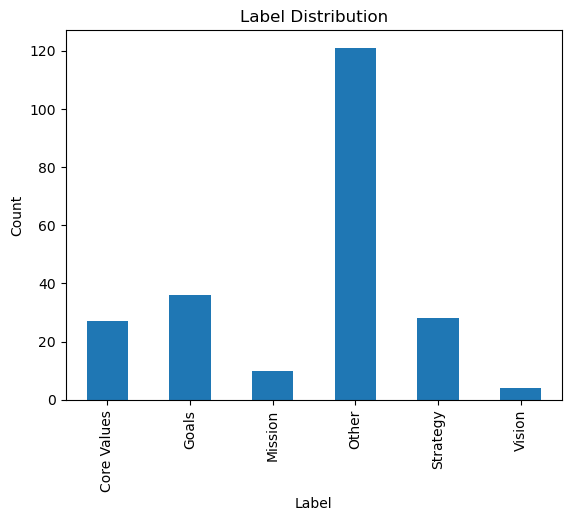

In [10]:
# Top 3 per label
top_per_label = []
for lab in LABELS:
    subset = df[df['label']==lab].sort_values('score', ascending=False).head(3)
    if len(subset):
        top_per_label.append(subset)
if len(top_per_label):
    display(pd.concat(top_per_label)[["page","label","score","text"]])

# Label distribution
lab_counts = df['label'].value_counts().sort_index()
plt.figure()
lab_counts.plot(kind='bar')
plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()


## 10) Save CSV + JSON

### Save the resulting candidates into cvs and json files which we can use to feed in our model.

In [11]:

def save_outputs(rows, out_dir, stem):
    out = Path(out_dir); out.mkdir(parents=True, exist_ok=True)
    csvp = out / f"{stem}.csv"
    pd.DataFrame(rows).to_csv(csvp, index=False)
    grouped = {lab: [] for lab in LABELS}
    for r in rows:
        if r["label"] in grouped:
            grouped[r["label"]].append({"page": r["page"], "score": r["score"], "text": r["text"]})
    jsonp = out / f"{stem}.json"
    jsonp.write_text(json.dumps(grouped, indent=2, ensure_ascii=False), encoding="utf-8")
    return str(jsonp), str(csvp)

jsonp, csvp = save_outputs(rows, out_dir="/content/outputs", stem=Path(INPUT_PDF).stem)
print("Wrote JSON:", jsonp)
print("Wrote CSV :", csvp)


Wrote JSON: \content\outputs\Basic-Fit Annual_Report_2024_Webversion.json
Wrote CSV : \content\outputs\Basic-Fit Annual_Report_2024_Webversion.csv


In [12]:
import os
import pandas as pd

# Make sure the 'outputs' folder exists
os.makedirs("/content/outputs", exist_ok=True)

# Extract text from your PDF
INPUT_PDF = r"C:\Users\kaile\Downloads\Basic-Fit Annual_Report_2024_Webversion.pdf"

rows = extract_rules_only(INPUT_PDF)
df = pd.DataFrame(rows)

# Save the extracted results to CSV
df.to_csv("/content/outputs/basicfit.csv", index=False)

print("✅ Extracted and saved to /content/outputs/basicfit.csv")


✅ Extracted and saved to /content/outputs/basicfit.csv


In [13]:
# === INPUT & OUTPUT PATHS ===
src_path = "/content/outputs/basicfit.csv"   # change this if needed
dst_all = "basicfit_clean_full.csv"
dst_no_other = "basicfit_clean_no_other.csv"
dst_jsonl = "basicfit_clean.jsonl"

# === LOAD DATA ===
df = pd.read_csv(src_path)

# --- Ensure Expected Columns ---
expected_cols = {"pdf","page","label","score","text"}
missing = expected_cols - set(df.columns)
if missing:
    raise ValueError(f"CSV missing required columns: {missing}")

# --- Basic type cleaning (prevents weird pandas issues later) ---
df["pdf"] = df["pdf"].astype(str)
df["label"] = df["label"].astype(str)
df["text"] = df["text"].astype(str).fillna("")

# page/score should be numeric
df["page"] = pd.to_numeric(df["page"], errors="coerce")
df["score"] = pd.to_numeric(df["score"], errors="coerce")

# drop rows with no text
df = df[df["text"].str.strip().ne("")].copy()
df.reset_index(drop=True, inplace=True)

In [14]:
# === CLEANING HELPERS ===

def normalize_text(t: str) -> str:
    """
    Light but safe normalization:
    - unicode normalization
    - remove URLs/emails
    - fix hyphen line-breaks
    - normalize whitespace WITHOUT destroying sentence boundaries
    """
    if not isinstance(t, str):
        t = "" if pd.isna(t) else str(t)

    # Normalize unicode (important for PDF artifacts)
    t = unicodedata.normalize("NFKC", t)

    # Remove URLs and emails (noise for semantic models)
    t = re.sub(r"https?://\S+|www\.\S+", " ", t)
    t = re.sub(r"\b[\w\.-]+@[\w\.-]+\.\w+\b", " ", t)

    # Fix hyphenated line breaks from PDFs
    t = re.sub(r"(\w)-\n(\w)", r"\1\2", t)

    # Normalize newlines but KEEP them (important for sentence / bullet splitting)
    t = re.sub(r"[ \t]*\n[ \t]*", "\n", t)
    t = re.sub(r"\n{3,}", "\n\n", t)

    # Collapse excessive spaces
    t = re.sub(r"[ \t]{2,}", " ", t)

    return t.strip()

In [15]:
# === BOILERPLATE REMOVAL ===

BOILERPLATE = [
    r"(?im)^\s*forward[- ]looking statements\b.*$",   # whole line
    r"(?im)^\s*safe harbor\b.*$",
    r"(?im)^\s*table of contents\b.*$",
    r"(?im)^\s*contents?\s*$",                        # line that is only "contents"
    r"(?im)^\s*disclaimer(s)?\b.*$",
    r"(?im)\bnon[- ]?ifrs\b",                         # term anywhere
    r"(?im)\bbasis of preparation\b"                  # term anywhere
]

BOILER_RE = [re.compile(p) for p in BOILERPLATE]

def clean_leading_symbols(t: str) -> str:
    """Remove decorative characters at start of lines, keep real bullet text."""
    if not isinstance(t, str):
        t = "" if pd.isna(t) else str(t)
    # remove up to 4 non-alnum chars at start of line (but keep bullets like • when followed by text)
    return re.sub(r"(?m)^\s*[^A-Za-z0-9]{1,4}\s*", "", t).strip()

def remove_boilerplate(t: str) -> str:
    if not isinstance(t, str):
        t = "" if pd.isna(t) else str(t)
    for r in BOILER_RE:
        t = r.sub(" ", t)
    t = re.sub(r"[ \t]{2,}", " ", t)
    t = re.sub(r"\n{3,}", "\n\n", t)
    return t.strip()

def is_meaningful(t: str) -> bool:
    """Filter garbage blocks (too short / too few letters)."""
    if not t or len(t.strip()) < 80:   # slightly stricter than 50
        return False
    letters = sum(ch.isalpha() for ch in t)
    if letters / max(1, len(t)) < 0.30:
        return False
    return True

# ---- Apply cleaning WITHOUT losing original evidence ----
df["text_clean"] = df["text"].map(clean_leading_symbols)
df["text_clean"] = df["text_clean"].map(normalize_text)       # uses your normalize_text()
df["text_clean"] = df["text_clean"].map(remove_boilerplate)

# Filter out garbage
df = df[df["text_clean"].map(is_meaningful)].copy()
df.reset_index(drop=True, inplace=True)

In [16]:
# === APPLY CLEANING ===
df["text"] = df["text"].fillna("").map(normalize_text).map(remove_boilerplate)
df = df[df["text"].map(is_meaningful)].copy()
df.reset_index(drop=True, inplace=True)

# Normalize label text
df["label"] = df["label"].astype(str).str.strip()

# Make sure page is usable for sorting/export
df["page"] = pd.to_numeric(df["page"], errors="coerce")

# === DE-DUPLICATE ===
def signature(t: str) -> str:
    t = (t or "").strip().lower()
    t = re.sub(r"\s+", " ", t)                  # stabilize whitespace
    return re.sub(r"\W+", "", t)[:500]          # longer key = fewer false collisions

df["_sig"] = df["text"].map(signature)

# Keep best scored duplicate (instead of arbitrary first)
df = df.sort_values(["label", "score", "page"], ascending=[True, False, True])
df = df.drop_duplicates(subset=["label", "_sig"], keep="first").drop(columns=["_sig"])
df.reset_index(drop=True, inplace=True)

# === OPTIONAL LENGTH CAP FOR MODEL USAGE ===
MAX_CHARS = 3500
def cap_text(x: str) -> str:
    x = x or ""
    return (x[:MAX_CHARS] + " …") if len(x) > MAX_CHARS else x

df["text"] = df["text"].map(cap_text)

# === SORT FOR READABILITY ===
sort_order = ["Mission", "Vision", "Core Values", "Strategy", "Goals", "Other"]
df["label"] = pd.Categorical(df["label"], categories=sort_order, ordered=True)
df = df.sort_values(["label", "page", "score"], ascending=[True, True, False])

# === SAVE OUTPUTS ===
df.to_csv(dst_all, index=False)
df[df["label"] != "Other"].to_csv(dst_no_other, index=False)

with open(dst_jsonl, "w", encoding="utf-8") as f:
    for _, row in df.iterrows():
        # Handle missing pages safely
        page_val = int(row["page"]) if pd.notna(row["page"]) else None
        f.write(json.dumps({
            "pdf": str(row["pdf"]),
            "page": page_val,
            "label": str(row["label"]),
            "text": str(row["text"])
        }, ensure_ascii=False) + "\n")

print("✅ Cleaning complete!")
print("Full cleaned CSV:", dst_all)
print("Without Other:", dst_no_other)
print("JSONL:", dst_jsonl)

df

✅ Cleaning complete!
Full cleaned CSV: basicfit_clean_full.csv
Without Other: basicfit_clean_no_other.csv
JSONL: basicfit_clean.jsonl


,pdf,page,label,score,text,source,text_clean
63,Basic-Fit Annual_Report_2024_Webversion.pdf,7,Mission,1.000000,"PROFILE Making fitness a Basic of life With 1,...",header_block,"PROFILE Making fitness a Basic of life With 1,..."
64,Basic-Fit Annual_Report_2024_Webversion.pdf,7,Mission,1.000000,COMPANY\nPROFILE\nMaking fitness a Basic of li...,front_matter,COMPANY\nPROFILE\nMaking fitness a Basic of li...
62,Basic-Fit Annual_Report_2024_Webversion.pdf,13,Mission,1.614286,Mission Making fitness accessible to everyone ...,header_block,Mission Making fitness accessible to everyone ...
65,Basic-Fit Annual_Report_2024_Webversion.pdf,28,Mission,1.000000,INFORMATION Basis for preparation of the Susta...,header_block,INFORMATION Basis for preparation of the Susta...
66,Basic-Fit Annual_Report_2024_Webversion.pdf,28,Mission,1.000000,Basic-Fit Annual Report 2024\nGENERAL\nINFORMA...,front_matter,Basic-Fit Annual Report 2024\nGENERAL\nINFORMA...
...,...,...,...,...,...,...,...
156,Basic-Fit Annual_Report_2024_Webversion.pdf,265,Other,0.000000,Listing Basic-Fit has been listed on Euronext ...,header_block,Listing Basic-Fit has been listed on Euronext ...
157,Basic-Fit Annual_Report_2024_Webversion.pdf,265,Other,0.000000,Share price development The closing price for ...,header_block,Share price development The closing price for ...
158,Basic-Fit Annual_Report_2024_Webversion.pdf,266,Other,0.000000,"Shareholders Under Dutch law, shareholdings of...",header_block,"Shareholders Under Dutch law, shareholdings of..."
159,Basic-Fit Annual_Report_2024_Webversion.pdf,267,Other,0.000000,"BASIC-FIT Amounts in € million, unless stated ...",header_block,"BASIC-FIT Amounts in € million, unless stated ..."


# Split into smaller chunks 

In [17]:
# Split each chunk into sentences
def split_sentences(text: str):
    if not isinstance(text, str):
        return []
    t = text.strip()
    if not t:
        return []
    # split on punctuation end + whitespace
    parts = re.split(r'(?<=[.!?])\s+', t)
    # also split on line-break-like separators (if any survived)
    parts = [p.strip() for p in parts if p and len(p.strip()) > 0]
    return parts

In [18]:
split_sentences(df["text_clean"].iloc[0])[:5]

['PROFILE Making fitness a Basic of life With 1,575 clubs and more than 4.25 million memberships, Basic-Fit is Europe’s largest and fastest-growing fitness chain.',
 'Close to 9,000 employees across six countries embrace its mission to make fitness accessible to everyone and a habit people love.',
 'Our community is guided by our BASIC values, these being Be, Accessible, Smart, Inclusive, and Committed.',
 'Every day we have a positive impact on the lives of millions of people by offering affordable and high-value fitness solutions.',
 'As a technology-driven company, our products and services are accessible, scalable and personalised.']

As we can see here, the big chunks of data in one statement, have different sentences that can be part of the GEA framework statement. For this reason, the next step will be not to look for the best statemnt in each of this big chunk statements, rather besmart on how can be classified again to have a better classification.

# Multi-label classifications classifyer

We are going to test this model in the first statement that we generated after filtering out the extracted statements in a way that we can target the best sentencees of each chunk and then tailor the sentence to the correct classified GEA framework statement.

In [20]:
# Model paraphrase-multilingual for better understandding in NL/EN
model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

To support both Dutch and English statements, we used a multilingual sentence embedding model. Instead of relying on long textual definitions, we represented each GEA category using short semantic anchor phrases, optionally in both languages. This improves robustness while keeping the model lightweight and explainable.

In [21]:
# Define label queries (definitions)
#  Use definitions like ' semantic anchors' 
queries = {
  "Mission": "Definition: A mission is a brief, typically one sentence, statement that defines the fundamental purpose of an enterprise that is'enduringly pursued but never fulfilled'.", 
  "Vision": "Definition: An enterprise vision is a concise statement that operationalises a mission, it is external and market oriented and should express, preferably in aspirational terms, how the enterprise intends to be perceived by the world",
  "Core Values": "Definition: A core value statement for an enterprise prescribes a set of desired behaviours, character and culture and is required for an enterprise to be, or become, successful within its formulated vision. Core values are used to indicate the value platforms from which the enterprise wants to operate and, in the most fundamental sense, they give substance and direction to what is important for an enterprise. We consider core values to be guiding statements for enterprises held at the highest level of purpose. Core values can also be referred to as statements of the fundamental principles of an enterprise. It is what management considers most important for the enterprises functioning, and considers critical for behaviour within an enterprise. Core values are not easily changed.",  
  "Strategy": "Definition: A strategy statement of an enterprise is a form of comprehensive master plan in which it is stated how an enterprise will achieve its goals. A strategy statement outlines the way an enterprise wants to achieve its goals, at which the 'whats, mission, vision, core values, goals, of the enterprise are translated into the 'how. How will the enterprise achieve its goals? This strategy-building process is generally carried out continuously within an enterprise, both for the shorter, medium and longer term development of the enterprise.",
  "Goals": "A goal statement is a formulation of a desired stage of development for an enterprise working towards achieving the enterprise's vision. Goals are a set of ambitions that an enterprise has, translated into short, medium and long-term goals. The term goals at this level is used to indicate the collective ambitions, for example, customer focus, continuity, sustainability, profit growth and internationalisation. Goals at the level of purpose of the enterprise are also referred to in the literature as 'goals. To make a distinction: objectives on a more concrete level can be referred to as 'targets' or 'objectives. This creates a goal hierarchy with, at the top the mission, vision and core values and the goals determined within those frameworks, followed by the objectives derived from this."
}

q_labels = list(queries.keys())
q_emb = model.encode(list(queries.values()), normalize_embeddings=True)

In [22]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def classify_sentences(sentences):
    sent_emb = model.encode(sentences, normalize_embeddings=True)
    sims = cosine_similarity(sent_emb, q_emb)  # shape: (n_sent, n_labels)

    best_idx = sims.argmax(axis=1)
    best_conf = sims.max(axis=1)

    preds = []
    for s, i, c in zip(sentences, best_idx, best_conf):
        preds.append((s, q_labels[i], float(c)))
    return preds

In [23]:
sents = [
 'PROFILE Making fitness a Basic of life With 1,575 clubs and more than 4.25 million memberships, Basic-Fit is Europe’s largest and fastest-growing fitness chain.',
 'Close to 9,000 employees across six countries embrace its mission to make fitness accessible to everyone and a habit people love.',
 'Our community is guided by our BASIC values, these being Be, Accessible, Smart, Inclusive, and Committed.',
 'Every day we have a positive impact on the lives of millions of people by offering affordable and high-value fitness solutions.',
 'As a technology-driven company, our products and services are accessible, scalable and personalised.'
]

classify_sentences(sents)

[('PROFILE Making fitness a Basic of life With 1,575 clubs and more than 4.25 million memberships, Basic-Fit is Europe’s largest and fastest-growing fitness chain.',
  'Core Values',
  0.22309570014476776),
 ('Close to 9,000 employees across six countries embrace its mission to make fitness accessible to everyone and a habit people love.',
  'Goals',
  0.26197078824043274),
 ('Our community is guided by our BASIC values, these being Be, Accessible, Smart, Inclusive, and Committed.',
  'Core Values',
  0.43355032801628113),
 ('Every day we have a positive impact on the lives of millions of people by offering affordable and high-value fitness solutions.',
  'Goals',
  0.17580492794513702),
 ('As a technology-driven company, our products and services are accessible, scalable and personalised.',
  'Vision',
  0.2946634888648987)]

In this example, we can see that the statements are no longer big and that each of the sentences are now classified correctly. After this we prepare our dataset to be process in this way: 

In [24]:
# Keep multiple statements
def extract_multi_statements(sentences, conf_thresh=0.40):
    preds = classify_sentences(sentences)

    grouped = {lab: [] for lab in q_labels}
    for sent, lab, conf in preds:
        if conf >= conf_thresh:
            grouped[lab].append((sent, conf))

    return grouped, preds

## Apply multi-label classifier in the dataset

In [25]:
# Classify a list of sentences
def classify_sentence_list(sentences):
    sent_emb = model.encode(sentences, normalize_embeddings=True)
    sims = cosine_similarity(sent_emb, q_emb)  # (n_sent x n_labels)

    best_idx = sims.argmax(axis=1)
    best_conf = sims.max(axis=1)

    out = []
    for s, i, c in zip(sentences, best_idx, best_conf):
        out.append((s, q_labels[i], float(c)))
    return out

In [26]:
# Build a sentence table (only splitting long chunks)
def build_sentence_table(df, text_col="text_clean", len_thresh=300, sent_thresh=2, max_sents=12):
    rows = []
    chunk_id = 0

    for idx, r in df.iterrows():
        chunk_id += 1
        text = str(r.get(text_col, "") or "").strip()

        if not text:
            continue

        sents = split_sentences(text)

        # decide whether to split or keep as one
        do_split = (len(text) > len_thresh) or (len(sents) > sent_thresh)

        if do_split:
            sents = sents[:max_sents]  # cap for speed
        else:
            sents = [text]  # keep as one row

        # classify sentences
        preds = classify_sentence_list(sents)

        for sid, (sent, pred, conf) in enumerate(preds, start=1):
            rows.append({
                "pdf": r.get("pdf"),
                "page": r.get("page"),
                "source": r.get("source"),
                "source_chunk_id": chunk_id,
                "sentence_id": sid,
                "sentence_text": sent,
                "pred_label": pred,
                "conf": conf,
                # keep original label for traceability
                "orig_label": r.get("label"),
                "orig_score": r.get("score"),
            })

    return pd.DataFrame(rows)

sent_df = build_sentence_table(df)
sent_df.head()

,pdf,page,source,source_chunk_id,sentence_id,sentence_text,pred_label,conf,orig_label,orig_score
0,Basic-Fit Annual_Report_2024_Webversion.pdf,7,header_block,1,1,"PROFILE Making fitness a Basic of life With 1,...",Core Values,0.223096,Mission,1.0
1,Basic-Fit Annual_Report_2024_Webversion.pdf,7,header_block,1,2,"Close to 9,000 employees across six countries ...",Goals,0.261971,Mission,1.0
2,Basic-Fit Annual_Report_2024_Webversion.pdf,7,header_block,1,3,"Our community is guided by our BASIC values, t...",Core Values,0.433550,Mission,1.0
3,Basic-Fit Annual_Report_2024_Webversion.pdf,7,header_block,1,4,Every day we have a positive impact on the liv...,Goals,0.175805,Mission,1.0
4,Basic-Fit Annual_Report_2024_Webversion.pdf,7,header_block,1,5,"As a technology-driven company, our products a...",Vision,0.294663,Mission,1.0


In [27]:
len(sent_df)

1332

In [28]:
sent_df.loc[0, "sentence_text"]

'PROFILE Making fitness a Basic of life With 1,575 clubs and more than 4.25 million memberships, Basic-Fit is Europe’s largest and fastest-growing fitness chain.'

In [29]:
cid = sent_df["source_chunk_id"].iloc[0]

print("ORIGINAL TEXT:")
print(df.loc[df.index[0], "text_clean"])
print("\n" + "="*80 + "\n")
print("SENTENCE CHUNKS:")
for s in sent_df[sent_df["source_chunk_id"] == cid]["sentence_text"]:
    print("-", s)

ORIGINAL TEXT:
PROFILE Making fitness a Basic of life With 1,575 clubs and more than 4.25 million memberships, Basic-Fit is Europe’s largest and fastest-growing fitness chain. Close to 9,000 employees across six countries embrace its mission to make fitness accessible to everyone and a habit people love. Our community is guided by our BASIC values, these being Be, Accessible, Smart, Inclusive, and Committed. Every day we have a positive impact on the lives of millions of people by offering affordable and high-value fitness solutions. As a technology-driven company, our products and services are accessible, scalable and personalised. Our inclusive model As a market leader, we are here for everyone. We offer a variety of membership options, tailored to individual needs. Our subscriptions grant access to our club facilities, as well as all the advantages of the Basic-Fit app. Our self-developed and maintained app offers nutrition advice, virtual group lessons, and hundreds of training pro

Here we can already see a HUGE difference with each statement. Now instead of having big chunk of sparse information. We have a well written sentence with meaning and we and the model can now easily indentify and classify which statement is.

In [30]:
CONF_SENT = 0.20

In [31]:
final_table = (
    sent_df
    .loc[sent_df["conf"] >= CONF_SENT,
         ["pdf", "page", "source_chunk_id", "sentence_text", "pred_label", "conf"]]
    .reset_index(drop=True)
)
final_table.head(20)

,pdf,page,source_chunk_id,sentence_text,pred_label,conf
0,Basic-Fit Annual_Report_2024_Webversion.pdf,7,1,"PROFILE Making fitness a Basic of life With 1,...",Core Values,0.223096
1,Basic-Fit Annual_Report_2024_Webversion.pdf,7,1,"Close to 9,000 employees across six countries ...",Goals,0.261971
2,Basic-Fit Annual_Report_2024_Webversion.pdf,7,1,"Our community is guided by our BASIC values, t...",Core Values,0.433550
3,Basic-Fit Annual_Report_2024_Webversion.pdf,7,1,"As a technology-driven company, our products a...",Vision,0.294663
4,Basic-Fit Annual_Report_2024_Webversion.pdf,7,1,"Our inclusive model As a market leader, we are...",Vision,0.270725
5,Basic-Fit Annual_Report_2024_Webversion.pdf,7,1,"We offer a variety of membership options, tail...",Goals,0.258543
6,Basic-Fit Annual_Report_2024_Webversion.pdf,7,1,Our subscriptions grant access to our club fac...,Core Values,0.266352
7,Basic-Fit Annual_Report_2024_Webversion.pdf,7,1,Our customer-centric approach enables everyone...,Core Values,0.272131
8,Basic-Fit Annual_Report_2024_Webversion.pdf,7,1,"Members can track their progress, check a club...",Strategy,0.200441
9,Basic-Fit Annual_Report_2024_Webversion.pdf,7,2,COMPANY\nPROFILE\nMaking fitness a Basic of li...,Core Values,0.258872


Now, this is thee final result that we wanted to achieve. This will be displayed in the final demo. But as you can see there are still some misclassifications that we have to try to classify correct. The next step we will focus on this step and then we can continue with the demo.

# Misclassification with BERT

### Improvement 1: Use label-specific cues
We are going to use now label-specific cues, because GEA statements have distinct semantic signals, we are going to make that explicit by scoring against multiple cues per label.

In [32]:
# Model paraphrase-multilingual for better understandding in NL/EN
model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

In [33]:
# Define multiple short cues per label 
label_cues = {
    "Mission": [
        "why the organization exists",
        "what the company does today",
        "purpose of the organization"
    ],
    "Vision": [
        "desired future of the organization",
        "long-term aspiration",
        "what the organization wants to become"
    ],
    "Core Values": [
        "core values and principles",
        "beliefs that guide behavior",
        "integrity, respect, responsibility"
    ],
    "Strategy": [
        "how the organization will achieve its goals",
        "strategic priorities",
        "approach to competition and growth"
    ],
    "Goals": [
        "specific objectives or targets",
        "measurable outcomes",
        "short- or long-term goals"
    ]
}

In [34]:
# Embed cues ones 
cue_texts, cue_labels = [], []
for lab, cues in label_cues.items():
    for c in cues:
        cue_texts.append(c)
        cue_labels.append(lab)

cue_emb = model.encode(cue_texts, normalize_embeddings=True)

In [35]:
# Classify sentence by best cue match
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def classify_sentence_cues(sentence):
    emb = model.encode([sentence], normalize_embeddings=True)
    sims = cosine_similarity(emb, cue_emb).flatten()
    idx = sims.argmax()
    return cue_labels[idx], float(sims[idx])

In [36]:
# Apply to the whole table
final_table["better_label"], final_table["better_conf"] = zip(
    *final_table["sentence_text"].apply(classify_sentence_cues)
)

In [37]:
final_table.head()

,pdf,page,source_chunk_id,sentence_text,pred_label,conf,better_label,better_conf
0,Basic-Fit Annual_Report_2024_Webversion.pdf,7,1,"PROFILE Making fitness a Basic of life With 1,...",Core Values,0.223096,Vision,0.312756
1,Basic-Fit Annual_Report_2024_Webversion.pdf,7,1,"Close to 9,000 employees across six countries ...",Goals,0.261971,Strategy,0.395925
2,Basic-Fit Annual_Report_2024_Webversion.pdf,7,1,"Our community is guided by our BASIC values, t...",Core Values,0.433550,Core Values,0.497449
3,Basic-Fit Annual_Report_2024_Webversion.pdf,7,1,"As a technology-driven company, our products a...",Vision,0.294663,Mission,0.428903
4,Basic-Fit Annual_Report_2024_Webversion.pdf,7,1,"Our inclusive model As a market leader, we are...",Vision,0.270725,Vision,0.341459


The final table stills missclassified mission vs vision . Core Values seems to be classified correctly. So we are going to further fine-tuning the misclassification until we have an acceptable table with more than 95% correct classifications. 

### Improvement 2: Rule-assisted override 
Some GEA classes are almost rule-based. So we are going to use rule-assisted override, a lightweight post-processing step that corrects obvious GEA cases (Mission, Vision, Values) using keyword rules, improving precision with almost no computational cost.

In [38]:
# Post-preprocessing 
def rule_override(text, current_label):
    t = text.lower()

    # ---- CORE VALUES ----
    if any(w in t for w in [
        "values", "value", "integrity", "respect", "inclusive", "inclusion",
        "committed", "commitment", "ethics", "ethical", "principles"
    ]):
        return "Core Values"

    # ---- MISSION ----
    if any(w in t for w in [
        "mission", "purpose", "why we", "why we exist", "exist to", "reason for being"
    ]):
        return "Mission"

    # ---- VISION ----
    if any(w in t for w in [
        "vision", "future", "aspire", "aspiration", "aim to become",
        "we want to be", "long-term ambition"
    ]):
        return "Vision"

    # ---- STRATEGY ----
    if any(w in t for w in [
        "strategy", "strategic", "strategic priorities", "our approach",
        "focus on", "we focus on", "how we will", "roadmap",
        "growth strategy", "business strategy", "operational excellence"
    ]):
        return "Strategy"

    # ---- GOALS ----
    if any(w in t for w in [
        "goal", "goals", "objective", "objectives", "target", "targets",
        "aim to", "aims to", "plan to", "we plan to",
        "by 20", "%", "increase", "reduce"
    ]):
        return "Goals"

    return current_label

In [39]:
# Apply again to final table
final_table["final_label"] = final_table.apply(
    lambda r: rule_override(r["sentence_text"], r["better_label"]),
    axis=1
)

In [56]:
final_table.head()

,pdf,page,source_chunk_id,statement,gea_category
0,Basic-Fit Annual_Report_2024_Webversion.pdf,7,1,"PROFILE Making fitness a Basic of life With 1,...",Vision
1,Basic-Fit Annual_Report_2024_Webversion.pdf,7,1,"Close to 9,000 employees across six countries ...",Mission
2,Basic-Fit Annual_Report_2024_Webversion.pdf,7,1,"Our community is guided by our BASIC values, t...",Core Values
3,Basic-Fit Annual_Report_2024_Webversion.pdf,7,1,"As a technology-driven company, our products a...",Mission
4,Basic-Fit Annual_Report_2024_Webversion.pdf,7,1,"Our inclusive model As a market leader, we are...",Core Values


In [41]:
# If cue confidence is weak, keep the original prediction:
# CONF_CUE = 0.18

#final_table["final_label"] = np.where(
    #final_table["better_conf"] >= CONF_CUE,
    #final_table["better_label"],
    #final_table["pred_label"])

In [42]:
# Only keep the final_label
final_table = final_table[
    ["pdf", "page", "source_chunk_id", "sentence_text", "final_label"]
].copy()

In [43]:
final_table = final_table.rename(columns={
    "sentence_text": "statement",
    "final_label": "gea_category"
})

In [57]:
final_table

,pdf,page,source_chunk_id,statement,gea_category
0,Basic-Fit Annual_Report_2024_Webversion.pdf,7,1,"PROFILE Making fitness a Basic of life With 1,...",Vision
1,Basic-Fit Annual_Report_2024_Webversion.pdf,7,1,"Close to 9,000 employees across six countries ...",Mission
2,Basic-Fit Annual_Report_2024_Webversion.pdf,7,1,"Our community is guided by our BASIC values, t...",Core Values
3,Basic-Fit Annual_Report_2024_Webversion.pdf,7,1,"As a technology-driven company, our products a...",Mission
4,Basic-Fit Annual_Report_2024_Webversion.pdf,7,1,"Our inclusive model As a market leader, we are...",Core Values
...,...,...,...,...,...
557,Basic-Fit Annual_Report_2024_Webversion.pdf,264,185,Basic-Fit adheres strictly to the applicable r...,Core Values
558,Basic-Fit Annual_Report_2024_Webversion.pdf,266,188,"Shareholders Under Dutch law, shareholdings of...",Goals
559,Basic-Fit Annual_Report_2024_Webversion.pdf,266,188,According to the AFM’s Substantial Holdings re...,Core Values
560,Basic-Fit Annual_Report_2024_Webversion.pdf,266,188,"Shareholders holding more than 3% René Moos, o...",Goals


In [74]:
# Save table in folder
final_table.to_csv("gea_final_table.csv", index=False)
print("✅ Extracted and saved gea_final_table.csv")

✅ Extracted and saved gea_final_table.csv


In [ ]:
# Save table excel file (client)
#final_table.to_excel("gea_final_table.xlsx", index=False)

Here we can see that in the final table, we already have a nice table with the final statement and the GEA category of each statement. At the end, in the demo, the client or experts can select the ones that are the correct ones and modify the label. So in this case the label can be an indicative of the extracted text but not a definitive label, making this model a better alternative than to extract manually statements from different pdfs.

### Last step: Sanity checks

Just to be sure everything is in order:


In [58]:
# ✅ Check size isn’t exploding and columns are correct
final_cols = ["pdf","page","source_chunk_id","sentence_text","final_label"]
print("Final rows:", len(final_table))
print("Final columns:", list(final_table.columns))
final_table.head(5)

Final rows: 562
Final columns: ['pdf', 'page', 'source_chunk_id', 'statement', 'gea_category']


,pdf,page,source_chunk_id,statement,gea_category
0,Basic-Fit Annual_Report_2024_Webversion.pdf,7,1,"PROFILE Making fitness a Basic of life With 1,...",Vision
1,Basic-Fit Annual_Report_2024_Webversion.pdf,7,1,"Close to 9,000 employees across six countries ...",Mission
2,Basic-Fit Annual_Report_2024_Webversion.pdf,7,1,"Our community is guided by our BASIC values, t...",Core Values
3,Basic-Fit Annual_Report_2024_Webversion.pdf,7,1,"As a technology-driven company, our products a...",Mission
4,Basic-Fit Annual_Report_2024_Webversion.pdf,7,1,"Our inclusive model As a market leader, we are...",Core Values


In [60]:
# ✅ Check label distribution
final_table["gea_category"].value_counts(dropna=False)

gea_category
Strategy       182
Core Values    134
Vision          92
Goals           88
Mission         66
Name: count, dtype: int64

In [65]:
# Detect “profile/noise” contamination
final_table.assign(n=final_table["statement"].str.len()) \
          .sort_values("n", ascending=False) \
          .head(15)[["gea_category","statement"]]

,gea_category,statement
561,Goals,Alternative performance measures Term Definiti...
110,Core Values,Process for assessing double materiality Susta...
174,Core Values,Basic-Fit Annual Report 2024\nValue creation m...
374,Mission,objective CCM 0 0.54 0 0 0 0 CCA 0 0 0 0 0 WTR...
344,Vision,"Management Board\nDirector of Treasury, IR and..."
542,Core Values,Based on our procedures performed and the evid...
465,Goals,"Objective Weight Year Condition René Moos, CEO..."
529,Vision,8.1 Remunerations of key management personnel ...
370,Core Values,"Finally, the regulation defines opex as costs ..."
523,Strategy,Consolidated statement of financial position A...


In [66]:
# Only apply removal if it’s clearly polluting.
#def looks_like_profile(s):
    #t = s.lower()
    #return any(x in t for x in ["employees", "million", "clubs", "countries", "revenue", "€", "$"]) and len(t) < 220

#profile_like = final_table["sentence_text"].apply(looks_like_profile).mean()
#print("Profile-like ratio:", profile_like)

In [67]:
# ✅ Time the core step on a small batch
import time
batch = df["text_clean"].dropna().head(200).tolist()

t0 = time.time()
_ = model.encode(batch, normalize_embeddings=True)
print("Encode 200 rows seconds:", round(time.time()-t0, 2))

Encode 200 rows seconds: 14.09


In [70]:
tmp = pd.read_csv("gea_final_table.csv")
print(tmp.shape)
tmp.head(2)

(562, 5)


,pdf,page,source_chunk_id,statement,gea_category
0,Basic-Fit Annual_Report_2024_Webversion.pdf,7,1,"PROFILE Making fitness a Basic of life With 1,...",Vision
1,Basic-Fit Annual_Report_2024_Webversion.pdf,7,1,"Close to 9,000 employees across six countries ...",Mission
